In [3]:
using ElectricGrid
using DifferentialEquations

Basic setup for a small electric grid with one source and one load. 
And ofcourse a cable inbetween.

In [5]:
SSPRK33()

SSPRK33(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))

In [2]:
CM = [0. 1.
     -1. 0.]

S_source = 1e4
S_load = 1e2
pf_load = 1
v_rms = 230
R_load, L_load, X, Z = ParallelLoadImpedance(S_load, pf_load, v_rms);

Here we set up any environment with nonlinear values.

In [3]:
parameters_linear = Dict{Any, Any}(
    "source" => Any[
                    Dict{Any, Any}("pwr" => S_source, "control_type" => "classic", "mode" => "Swing", "fltr" => "LC", "i_limit" => 1e4, "v_limit" => 1e4,),
                    ],
    "load"   => Any[
                    Dict{Any, Any}("impedance" => "R", "R" => R_load, "v_limit" => 1e4, "i_limit" => 1e4)
                    ],
    "cable"   => Any[
                    Dict{Any, Any}("R" => 1e-3, "L" => 1e-4, "C" => 1e-4),
                    ],
    "grid" => Dict{Any, Any}("fs"=>1e4, "phase"=>3, "v_rms"=>230, "f_grid" => 50, "ramp_end"=>0.00)
)

env_linear = ElectricGridEnv(CM = CM, parameters = parameters_linear, verbosity = 2);

┌ Info: Normalization is done based on the defined parameter limits.
└ @ ElectricGrid /Users/benediktbrueck/Documents/GitHub/ElectricGrid.jl/src/electric_grid_env.jl:358
┌ Info: Time simulation run time: 0.0499 [s] ~> 500 steps
└ @ ElectricGrid /Users/benediktbrueck/Documents/GitHub/ElectricGrid.jl/src/electric_grid_env.jl:359


Here we set up the environment the same except the inductance of the cable (L) is set to an orbitrary function. In this example its just a constant function to show, that it gives a similar result.

And another key feature is, that you can set a solver for the nonlinear simulation. Which is show in an INFO. (the default one is SSPRK22) more are found here [Differential Equations](https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/).

In [4]:
parameters_nonlinear = Dict{Any, Any}(
    "source" => Any[
                    Dict{Any, Any}("pwr" => S_source, "control_type" => "classic", "mode" => "Swing", "fltr" => "LC", "i_limit" => 1e4, "v_limit" => 1e4,),
                    ],
    "load"   => Any[
                    Dict{Any, Any}("impedance" => "R", "R" => R_load, "v_limit" => 1e4, "i_limit" => 1e4)
                    ],
    "cable"   => Any[
                    Dict{Any, Any}("R" => 1e-3, "L" => x->1e-4, "C" => 1e-4),
                    ],
    "grid" => Dict{Any, Any}("fs"=>1e4, "phase"=>3, "v_rms"=>230, "f_grid" => 50, "ramp_end"=>0.00)
)

env_nonlinear = ElectricGridEnv(CM = CM, parameters = parameters_nonlinear, verbosity = 2, nonlinear_solver = SSPRK33());

┌ Info: Nonlinear Solver: Use SSPRK33 as solver.
└ @ ElectricGrid /Users/benediktbrueck/Documents/GitHub/ElectricGrid.jl/src/electric_grid_env.jl:167
┌ Info: Normalization is done based on the defined parameter limits.
└ @ ElectricGrid /Users/benediktbrueck/Documents/GitHub/ElectricGrid.jl/src/electric_grid_env.jl:358
┌ Info: Time simulation run time: 0.0499 [s] ~> 500 steps
└ @ ElectricGrid /Users/benediktbrueck/Documents/GitHub/ElectricGrid.jl/src/electric_grid_env.jl:359


In [5]:
# solve and simulate
value = 5

sol_nonlinear = []
for i = 1:1000
    env_nonlinear([0.5, 0.5, 0.5])
    append!(sol_nonlinear,env_nonlinear.x[value])
end

sol_linear = []
for i = 1:1000
    env_linear([0.5, 0.5, 0.5])
    append!(sol_linear,env_linear.x[value])
end

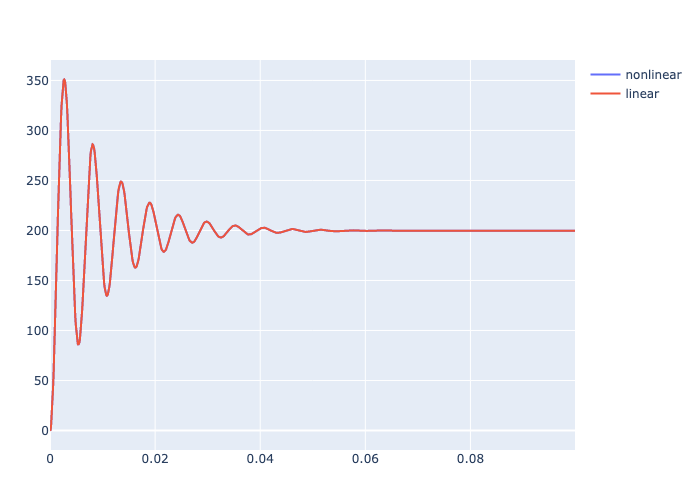

In [6]:
# Plot
t_nonlinear = collect(env_nonlinear.t0:env_nonlinear.ts:env_nonlinear.t)
p_nonlinear = scatter(x=t_nonlinear,y=sol_nonlinear,mode="lines",name="nonlinear")

t_linear = collect(env_linear.t0:env_linear.ts:env_linear.t)
p_linear = scatter(x=t_linear,y=sol_linear,mode="lines",name="linear")

plot([p_nonlinear,p_linear])